In [1]:
import cv2
import numpy as np
import mediapipe as mp
import math
from IPython.display import display, Image ,clear_output
import time
import keyboard
from transitions import Machine
from collections import deque

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [3]:
def showVideo(img, fps=30):     
    _, en_image = cv2.imencode('.jpg',img)
    img_obj = Image(data = en_image)
    clear_output(True)
    display(img_obj)
    time.sleep(1/fps)
    if keyboard.is_pressed('esc'):
        video.release()

In [4]:
def calculateSpatialRelationship(p1, p2):  
    relationship = None
    if len(p1) == 2 & len(p2) == 2:
        if p1[1] < p2[1]:
            relationship = 'above'
        elif p1[1] > p2[1]:
            relationship = 'below'
   
    return relationship

In [5]:
def findPosition(img):
    lmList = []
    if results.pose_landmarks:
        for id, lm in enumerate(results.pose_landmarks.landmark):
            h, w, c = img.shape
            cx, cy = int(lm.x * w), int(lm.y * h)
            lmList.append([id, cx, cy])
    return lmList

In [6]:
def findPosition3D():
    lmList = []
    if results.pose_world_landmarks:
        for id, lm in enumerate(results.pose_world_landmarks.landmark):
            x, y, z = (lm.x, -lm.y, -lm.z)
            lmList.append([id, x, y, z])
    return lmList

In [7]:
#計算關節角度
def calculate_angle(a,b,c):
    a = np.array(a)# First
    b = np.array(b)# Mid
    c = np.array(c)# End

    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    degree = np.degrees(angle)
    
    return round(degree,1)

In [8]:
def caculateGesture(right_wrist_velocity_y,right_ankle_velocity_y,left_wrist_velocity_y,left_ankle_velocity_y,r_wrist_shoulder_sp_relation,l_wrist_shoulder_sp_relation,
            threshold = 20):
    if ((right_wrist_velocity_y and right_ankle_velocity_y ) < -threshold) and r_wrist_shoulder_sp_relation == 'above':
        gesture = 'ru'
        #return gesture
        
    elif (right_wrist_velocity_y and right_ankle_velocity_y ) > threshold:
        gesture = 'rd'
        #return gesture
    
    elif ((left_wrist_velocity_y and left_ankle_velocity_y ) < -threshold) and l_wrist_shoulder_sp_relation == 'above':
        gesture = 'lu'
        #return gesture
        
    elif (left_wrist_velocity_y and left_ankle_velocity_y ) > threshold:
        gesture = 'ld'
        #return gesture
        
    else:
        gesture = 'unknown'
        #return gesture
    return gesture

In [9]:
class HLRaction():
    
    states = ['UNKNOWN', 'RightUp', 'RightDown', 'LeftUp', 'LeftDown']
    
    def __init__(self):
        
        self.cycle_count = 0
        
        self.machine = Machine(model = self, states =HLRaction.states, initial = 'UNKNOWN',ignore_invalid_triggers = True)
        
        self.machine.add_transition(trigger = 'unknown', source = 'UNKNOWN', dest = 'UNKNOWN') #0
        self.machine.add_transition(trigger = 'ru', source = 'UNKNOWN', dest = 'RightUp') #1
        self.machine.add_transition(trigger = 'lu', source = 'UNKNOWN', dest = 'LeftUp') #2
        self.machine.add_transition(trigger = 'rd', source = 'RightUp', dest = 'RightDown') #3
        self.machine.add_transition(trigger = 'ld', source = 'LeftUp', dest = 'LeftDown') #4
        self.machine.add_transition(trigger = 'ru', source = 'RightDown', dest = 'UNKNOWN', after = 'update_cycle_count') #5
        self.machine.add_transition(trigger = 'lu', source = 'RightDown', dest = 'UNKNOWN', after = 'update_cycle_count') #5
        self.machine.add_transition(trigger = 'rd', source = 'RightDown', dest = 'UNKNOWN', after = 'update_cycle_count') #5
        self.machine.add_transition(trigger = 'ld', source = 'RightDown', dest = 'UNKNOWN', after = 'update_cycle_count') #5
        self.machine.add_transition(trigger = 'unknown', source = 'RRightDown', dest = 'UNKNOWN', after = 'update_cycle_count') #5
        self.machine.add_transition(trigger = 'ru', source = 'LeftDown', dest = 'UNKNOWN', after = 'update_cycle_count') #6
        self.machine.add_transition(trigger = 'lu', source = 'LeftDown', dest = 'UNKNOWN', after = 'update_cycle_count') #6
        self.machine.add_transition(trigger = 'rd', source = 'LeftDown', dest = 'UNKNOWN', after = 'update_cycle_count') #6
        self.machine.add_transition(trigger = 'ld', source = 'LeftDown', dest = 'UNKNOWN', after = 'update_cycle_count') #6
        self.machine.add_transition(trigger = 'unknown', source = 'LeftDown', dest = 'UNKNOWN', after = 'update_cycle_count') #6
         
    def update_cycle_count(self):
        self.cycle_count += 1   

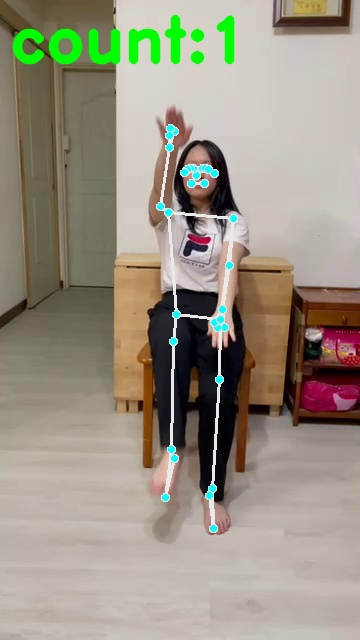

In [10]:
video = cv2.VideoCapture('../../video_data/(002)rising_same/OK.MOV')

action_detector = HLRaction()
pose = mp_pose.Pose(model_complexity=2,smooth_landmarks=True,min_detection_confidence=0.5, min_tracking_confidence=0.5)
pts_16 = deque(maxlen=5)
pts_28 = deque(maxlen=5)
pts_15 = deque(maxlen=5)
pts_27 = deque(maxlen=5)

counter = 0
while True:
    success, img = video.read()
    if not success:
        break
    if success:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
       
        dY_16,dY_28,dY_15,dY_27 = 0,0,0,0
        # 偵測landmarks
        results = pose.process(img)
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # 畫出landmarks
        mp_drawing.draw_landmarks(img, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(255,255,0), thickness=2, circle_radius=2),
                                mp_drawing.DrawingSpec(color=(233,233,233), thickness=2, circle_radius=2))
        # 存取keypoint座標 
        lmList = findPosition(img)
        #lmList3D = findPosition3D()
        #
        pts_16.appendleft((lmList[14][1],lmList[14][2]))             
        #loop over the set of tracked points
        for i in np.arange(1, len(pts_16)):
            # if either of the tracked points are None, ignore
            # them
            if pts_16[i - 1] is None or pts_16[i] is None:
                continue
            # check to see if enough points have been accumulated in
            # the buffer
            if counter >= 3 and i == 1 and pts_16[-3] is not None:
                # compute the difference between the x and y
                # coordinates and re-initialize the direction
                # text variables
                dX_16 = pts_16[-3][0] - pts_16[i][0]
                dY_16 = pts_16[i][1] - pts_16[-3][1]
                
                
        pts_28.appendleft((lmList[26][1],lmList[26][2]))             
        #loop over the set of tracked points
        for i in np.arange(1, len(pts_28)):
            # if either of the tracked points are None, ignore
            # them
            if pts_28[i - 1] is None or pts_28[i] is None:
                continue
            # check to see if enough points have been accumulated in
            # the buffer
            if counter >= 3 and i == 1 and pts_28[-3] is not None:
                # compute the difference between the x and y
                # coordinates and re-initialize the direction
                # text variables
                dX_28 = pts_28[-3][0] - pts_28[i][0]
                dY_28 = pts_28[i][1] - pts_28[-3][1]
                
        pts_15.appendleft((lmList[13][1],lmList[13][2]))             
        #loop over the set of tracked points
        for i in np.arange(1, len(pts_15)):
            # if either of the tracked points are None, ignore
            # them
            if pts_15[i - 1] is None or pts_15[i] is None:
                continue
            # check to see if enough points have been accumulated in
            # the buffer
            if counter >= 3 and i == 1 and pts_15[-3] is not None:
                # compute the difference between the x and y
                # coordinates and re-initialize the direction
                # text variables
                dX_15 = pts_15[-3][0] - pts_15[i][0]
                dY_15 = pts_15[i][1] - pts_15[-3][1]
                
                
        pts_27.appendleft((lmList[25][1],lmList[25][2]))             
        #loop over the set of tracked points
        for i in np.arange(1, len(pts_27)):
            # if either of the tracked points are None, ignore
            # them
            if pts_27[i - 1] is None or pts_27[i] is None:
                continue
            # check to see if enough points have been accumulated in
            # the buffer
            if counter >= 3 and i == 1 and pts_27[-3] is not None:
                # compute the difference between the x and y
                # coordinates and re-initialize the direction
                # text variables
                dX_27 = pts_27[-3][0] - pts_27[i][0]
                dY_27 = pts_27[i][1] - pts_27[-3][1]
        
        r_wrist_shoulder_sp_relation = calculateSpatialRelationship((lmList[14][1],lmList[14][2]),(lmList[12][1],lmList[12][2]))
        l_wrist_shoulder_sp_relation = calculateSpatialRelationship((lmList[13][1],lmList[13][2]),(lmList[11][1],lmList[11][2]))
                
                
        pose_now = caculateGesture(dY_16,dY_28,dY_15,dY_27,r_wrist_shoulder_sp_relation,l_wrist_shoulder_sp_relation,threshold = 5)
        
        if pose_now == 'ru':
            action_detector.ru()
        if pose_now == 'rd':
            action_detector.rd()
        if pose_now == 'lu':
            action_detector.lu()
        if pose_now == 'ld':
            action_detector.ld()
        if pose_now == 'unknown':
            action_detector.unknown()
        
        #angle = calculate_angle(lmList3D[16],lmList3D[14],lmList3D[12])
        
        # cv2.putText(img, "gesture:"+str(pose_now), (10,30),cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
        # cv2.putText(img, "velocity:"+str(dY_16), (10,55),cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)
        # cv2.putText(img,'state :'+str(action_detector.state), (10,80),cv2.FONT_HERSHEY_DUPLEX, 0.7, (0,  255, 0), 1, cv2.LINE_AA)
        cv2.putText(img, ('count:'+str(action_detector.cycle_count)), (10,60), cv2.FONT_HERSHEY_DUPLEX, 2, (0,  255, 0), 5, cv2.LINE_AA)  
        
        #save img
        cv2.imwrite('frame/'+str(counter).zfill(4)+'.jpg',img)
             
        showVideo(img,fps=30)
        
        #print(r_wrist_shoulder_sp_relation)
        #print(lmList3D[16])
        #print(angle)
        counter += 1
video.release()